In [ ]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import utils, hf

In [ ]:
s0 = np.identity(2)
sz = np.diag([1, -1])

norbs = 2

graphene = kwant.lattice.general(
    [[1, 0], [1 / 2, np.sqrt(3) / 2]], [[0, 0], [0, 1 / np.sqrt(3)]], norbs=norbs
)
a, b = graphene.sublattices

# create bulk system
bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
# add sublattice potential
m0 = 0

bulk_graphene[a.shape((lambda pos: True), (0, 0))] = m0 * s0
bulk_graphene[b.shape((lambda pos: True), (0, 0))] = -m0 * s0
# add hoppings between sublattices
bulk_graphene[graphene.neighbors(1)] = s0
bulk_graphene[graphene.neighbors(2)] = 1j * s0

# use kwant wraparound to sample bulk k-space
wrapped_syst = kwant.wraparound.wraparound(bulk_graphene)
wrapped_fsyst = wrapped_syst.finalized()

In [ ]:
def func_onsite(site, U):
    return U * np.ones((2, 2))

def func_hop(site1, site2, V):
    return V * np.ones((2, 2))

In [ ]:
Us = np.linspace(1e-6, 5, 10)
Vs = np.linspace(1e-6, 5, 1)

In [ ]:
from numpy.linalg import qr
from functools import partial

def scf_loop(mf, H_int, scf_syst, ks, hamiltonians_0, filling=2, max_neighbor=1):
    if np.linalg.norm(mf) < 1e-5:
        return 0
    # mf = mf.reshape(
    #     max_neighbor + len(graphene.sublattices),
    #     2,
    #     norbs,
    #     norbs,
    # )
    params = dict(mat=mf)
    mf_k = utils.syst2hamiltonian(syst=scf_syst, kxs=ks, kys=ks, params=params)

    H0_int = H_int[0, 0]

    # Generate the Hamiltonian
    hamiltonians = hamiltonians_0 + mf_k
    vals, vecs = np.linalg.eigh(hamiltonians)
    # Orthogonalize vectors
    vecs = qr(vecs)[0]
    # Compute new Fermi energy
    mf_k_new = hf.compute_mf(vals, vecs, filling, ks, H_int)

    diff = mf_k_new - mf_k
    shift = np.trace(np.average(diff, axis=(0,1)))
    diff -= shift / norbs / len(graphene.sublattices)

    if np.linalg.norm(mf_k_new) < 1e-5:
        return 0
    else:
        return np.linalg.norm(diff) / np.linalg.norm(mf_k_new)

In [ ]:
def generate_guess(max_neighbor, norbs):
    n_sub = len(graphene.sublattices)
    guess = np.zeros((n_sub + max_neighbor, 2, norbs, norbs))
    for i in range(n_sub):
        # Real part
        guess[i, 0] = np.random.rand(norbs, norbs)
        guess[i, 0] += guess[i, 0].T
        guess[i, 0] *= 0.5
        # Imag part
        guess[i, 1] = np.random.rand(norbs, norbs)
        guess[i, 1] -= guess[i, 1].T
        guess[i, 1] *= 0.5
    for neighbor in range(max_neighbor):
        # Real part
        guess[n_sub + neighbor, 0] = np.random.rand(norbs, norbs)
        # Imag part
        guess[n_sub + neighbor, 1] = np.random.rand(norbs, norbs)
    return guess

def generate_guess(max_neighbor, norbs):
    n_sub = len(graphene.sublattices)
    guess = np.zeros((n_sub + max_neighbor, 2, norbs, norbs))
    for i in range(n_sub):
        # Real part
        guess[i, 0] = np.diag(np.random.rand(norbs))
        # Imag part
        guess[i, 1] = np.diag(np.random.rand(norbs))
    for neighbor in range(max_neighbor):
        # Real part
        guess[n_sub + neighbor, 0] = np.diag(np.random.rand(norbs))
        # Imag part
        guess[n_sub + neighbor, 1] = np.diag(np.random.rand(norbs))
    return guess

In [108]:
import tinyarray as ta

def extract_hopping_vectors(builder):
    keep=None
    deltas=[]
    for hop, val in builder.hopping_value_pairs():
        a, b=hop
        b_dom = builder.symmetry.which(b)
        # Throw away part that is in the remaining translation direction, so we get
        # an element of 'sym' which is being wrapped
        b_dom = ta.array([t for i, t in enumerate(b_dom) if i != keep])
        deltas.append(b_dom)
    return np.asarray(deltas)

def generate_scf_syst(max_neighbor, syst):
    def scf_onsite(site, mat):
        if site.family == a:
            return mat[0, 0] + 1j * mat[0, 1]
        elif site.family == b:
            return mat[1, 0] + 1j * mat[1, 1]

    scf = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
    scf[syst.sites()] = scf_onsite
    for neighbor in range(max_neighbor):

        def scf_hopping(site1, site2, mat):
            return (
                mat[len(graphene.sublattices) + neighbor, 0]
                + 1j * mat[len(graphene.sublattices) + neighbor, 1]
            )

        scf[graphene.neighbors(neighbor + 1)] = scf_hopping
    deltas = extract_hopping_vectors(scf)
    wrapped_scf = kwant.wraparound.wraparound(scf).finalized()
    return wrapped_scf, deltas

from scipy.optimize import minimize, anderson, fmin, root


def generate_hint(syst, U, V, lattice, func_onsite, func_hop, params, ks):
    Uk = utils.potential2hamiltonian(
        syst=syst,
        lattice=graphene,
        func_onsite=func_onsite,
        func_hop=func_hop,
        params=dict(U=1, V=0),
        ks=ks,
    )

    Vk = utils.potential2hamiltonian(
        syst=syst,
        lattice=graphene,
        func_onsite=func_onsite,
        func_hop=func_hop,
        params=dict(U=0, V=1),
        ks=ks,
    )
    return U * Uk + V * Vk


def total_energy(mf, syst0, syst_mf, ks, max_neighbor, filling):
    mf = mf.reshape(
        max_neighbor + len(graphene.sublattices),
        2,
        norbs,
        norbs,
    )
    hamiltonians_0 = utils.syst2hamiltonian(kxs=ks, kys=ks, syst=syst0)
    scf_mf_k = utils.syst2hamiltonian(syst=syst_mf, kxs=ks, kys=ks, params=dict(mat=mf))
    vals, vecs = np.linalg.eigh(hamiltonians_0 + scf_mf_k)
    E_F = utils.get_fermi_energy(vals, filling)
    vals -= E_F
    N_filling = np.sum(vals < 0)
    E_total = np.sum(vals[vals < 0])
    E_p_atom = E_total / N_filling
    return E_p_atom


def compute_gap(U, V, max_neighbor=1, nk=12, filling=2):
    n_sub = len(graphene.sublattices)
    ks = np.linspace(0, 2 * np.pi, nk, endpoint=False)
    hamiltonians_0 = utils.syst2hamiltonian(kxs=ks, kys=ks, syst=wrapped_fsyst)
    # Generate interacting matrix
    H_int = generate_hint(
        syst=wrapped_syst,
        lattice=graphene,
        func_onsite=func_onsite,
        func_hop=func_hop,
        U=U,
        V=V,
        ks=ks,
        params={},
    )
    # Create a dummy kwant system for the mean-field
    scf_syst = generate_scf_syst(max_neighbor=max_neighbor, syst=wrapped_syst)

    # mf = minimize(
    #     scf_loop,
    #     generate_guess(max_neighbor=max_neighbor, norbs=norbs).flatten(),
    #     tol=1e-4,
    #     args=(H_int, scf_syst, ks, hamiltonians_0, filling, max_neighbor),
    # ).x
    fun = partial(
        scf_loop,
        H_int=H_int,
        scf_syst=scf_syst,
        ks=ks,
        hamiltonians_0=hamiltonians_0,
        filling=filling,
        max_neighbor=max_neighbor,
    )

    def callback(x, f):
        return x
    mf = anderson(
        fun,
        generate_guess(max_neighbor=max_neighbor, norbs=norbs),
        f_tol=1e-3,
        w0=0.5,
        M=1,
        callback=callback,
    )

    mf = mf.reshape(
        max_neighbor + len(graphene.sublattices),
        2,
        norbs,
        norbs,
    )
    ks = np.linspace(0, 2 * np.pi, 30, endpoint=False)
    hamiltonians_0 = utils.syst2hamiltonian(kxs=ks, kys=ks, syst=wrapped_fsyst)
    scf_mf_k = utils.syst2hamiltonian(
        syst=scf_syst, kxs=ks, kys=ks, params=dict(mat=mf)
    )
    vals, vecs = np.linalg.eigh(hamiltonians_0 + scf_mf_k)
    E_F = utils.get_fermi_energy(vals, 2)
    print("U=" + str(U) + " , V=" + str(V))
    extr = np.max(np.abs(scf_mf_k[0, 0]) - E_F * np.eye(n_sub * norbs))
    plt.matshow(
        (scf_mf_k[0, 0] - E_F * np.eye(n_sub * norbs)).real,
        cmap="RdBu_r",
        vmin=-extr,
        vmax=extr,
    )
    plt.colorbar()
    plt.show()
    emax = np.max(vals[vals <= E_F])
    emin = np.min(vals[vals > E_F])
    return np.abs(emin - emax)


from tqdm import tqdm

gap = []
for U in tqdm(Us):
    gap_U = []
    for V in Vs:
        gap_U.append(compute_gap(U, V))
    gap.append(gap_U)

  0%|          | 0/10 [00:00<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'hamiltonian_submatrix'

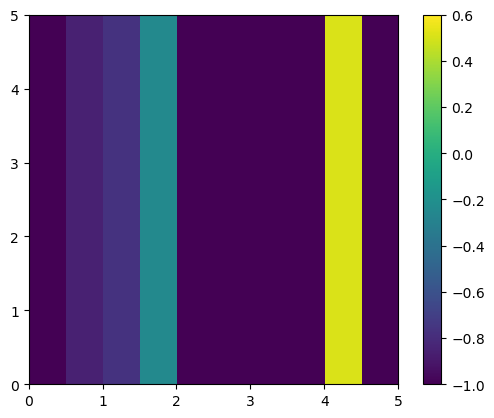

In [12]:
gap = np.asarray(gap, dtype=float)
plt.imshow(np.log10(gap).T, origin='lower', extent=(0, 5, 0, 5), vmin=-1, vmax=0.6)
plt.colorbar()

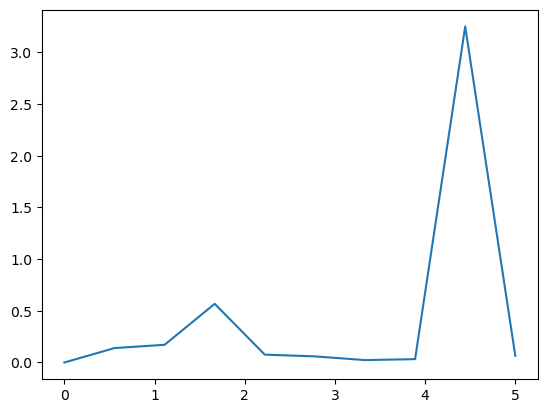

In [13]:
plt.plot(Us, gap)

In [8]:
ks = np.linspace(0, 2 * np.pi, 2, endpoint=False)
hamiltonians_0 = utils.syst2hamiltonian(kx=ks, ky=ks, syst=wrapped_fsyst)

TypeError: only length-1 arrays can be converted to Python scalars

In [17]:
params={}
# @np.vectorize
def h_k(kx, ky):
    return wrapped_fsyst.hamiltonian_submatrix(params={**params, **dict(k_x=kx, k_y=ky)})

In [19]:
vhk=np.vectorize(h_k)
vhk(kx=np.linspace(0,1),ky=[0])

TypeError: only length-1 arrays can be converted to Python scalars

In [50]:
max_neighbor=1
norbs=20
shape = (
    max_neighbor + len(graphene.sublattices),
    2,
    norbs,
    norbs
)
mf = np.random.rand(*shape)
mf2 = mf.flatten()
mf2 = mf2.reshape(*shape)

In [51]:
mf - mf2

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0.

In [152]:
deltas = extract_hopping_vectors(bulk_graphene)
nk=100
ks, dk = np.linspace(0, 2 * np.pi, nk, endpoint=False, retstep=True)
hamiltonians_0 = utils.syst2hamiltonian(kxs=ks, kys=ks, syst=wrapped_fsyst)

In [153]:
deltas

array([[ 0, -1],
       [ 0,  0],
       [ 1, -1],
       [-1,  0],
       [-1,  1],
       [ 0, -1],
       [-1,  0],
       [-1,  1],
       [ 0, -1]])

In [154]:
kxx, kyy = np.meshgrid(ks, ks)
deltas = np.asarray(deltas)
kxy = np.array([kxx, kyy])
hopps = np.sum(
    np.einsum(
        "ijk,jklm->ijklm",
        np.exp(1j * np.einsum("ij,jkl->ikl", deltas, kxy)),
        hamiltonians_0,
    ),
    axis=(1, 2),
) * (dk)**2 / (2 * np.pi)**2

In [155]:
hopps[7][:2,:2]

array([[4.0983883e-17-1.j, 0.0000000e+00+0.j],
       [0.0000000e+00+0.j, 4.0983883e-17-1.j]])

In [156]:
hopps[0][2:,:2]

array([[1.-1.04091735e-16j, 0.+0.00000000e+00j],
       [0.+0.00000000e+00j, 1.-1.04091735e-16j]])

In [140]:
kxy.shape

(2, 10, 10)

In [90]:
np.einsum("ij,jkl->ikl", deltas, kxy).shape

(3, 10, 10)

In [ ]:
deltas=[]
for hop, val in builder.hopping_value_pairs():
    a, b=hop
    b_dom = builder.symmetry.which(b)
    # Throw away part that is in the remaining translation direction, so we get
    # an element of 'sym' which is being wrapped
    b_dom = ta.array([t for i, t in enumerate(b_dom) if i != keep])
    deltas.append(b_dom)